# Elman-style syntax extraction models

In this project, we will first replicate Elman's (1990) results on discovering linguistic structure. We will then expand his results, using a broader and more naturalistic corpus.

Elman's contributions are foundational to modern artificial intelligence. His (1990) paper introduced recurrent neural networks, which currently form the architectural backbone of NLP. Moreover, the results Elman obtained are an impressive demonstration of the capacity of neural networks to learn syntactic and semantic categories.

### Packages
We begin by importing the packages we will need.

In [2]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib
%matplotlib inline
from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
import random
from tqdm import tqdm
from torch.distributions.categorical import Categorical

plt.style.use('dark_background')

RANDOM_SEED = 0
# random.seed(RANDOM_SEED)

### Loading the data
We begin by using Elman's original dataset. Elman's data was generated by a simple categorial grammar: we specify a set of sentence structures consisting of placeholder syntactic and semantic categories (such as `NOUN-ANIMATE`, `VERB-TRANSITIVE`, or `NOUN-FOOD`) as well as a list of lexical items for each category. Generating the data then consists in randomly choosing a sentence template and replacing each lexical category in the template by a word from that category. The words in each category are specified by hand.

We generate the 10_000 sentences of data in a separate file. Here, we load and process the data. Each word (token) in the vocabulary is represented by a number. Each training example is stored as as tensor of indices representing the corresponding words in the sentence.

In [3]:
# load sentences
with open('data/elman_sentences.txt', 'r') as fid:
    lines = fid.readlines()

# strip trailing whitespace
stripped_sentences = [l.strip() for l in lines]
# tokenize sentences
tokenized_sentences = [s.split() for s in stripped_sentences]
# add start and end of sentence markers
tokenized_sentences = [['<SOS>'] + s + ['<EOS>'] for s in tokenized_sentences]
# count tokens
unique_tokens = sorted(set(sum(tokenized_sentences, [])))
n_tokens = len(unique_tokens)
# mapping tokens to ints and vice-versa
tokens_to_ints = {t : i for i, t in enumerate(unique_tokens)}
ints_to_tokens = {i : t for i, t in enumerate(unique_tokens)}

# mapping sentences to tensors of ints
def sentence_to_tensor(token_list):
    """
    Input: list of tokens
    Output: 1D tensor containing the token encodings
    """
    indices = [tokens_to_ints[t] for t in token_list]
    return torch.tensor(indices)
# tensors of token indices representing sentences
training_tensors = [sentence_to_tensor(s) for s in tokenized_sentences]
n_train = len(training_tensors)

Let us illustrate our processing of the data.

In [4]:
print(f"Number of examples: {n_train}")
print(f"Number of unique tokens (including <SOS> and <EOS>): {n_tokens}")
print(f"Example tokenized sentence: {tokenized_sentences[0]}")
print(f"Corresponding tensor: {training_tensors[0]}")

Number of examples: 10000
Number of unique tokens (including <SOS> and <EOS>): 31
Example tokenized sentence: ['<SOS>', 'monster', 'break', 'plate', '<EOS>']
Corresponding tensor: tensor([ 1, 19,  5, 22,  0])


### Building the model
We now define a simple recurrent network inspired by Elman's own (1990) proposal. Elman uses a one-hot encoding of the vocabulary. In line with contemporary NLP practice, we will instead use a continuous embedding vector (of size `hidden_size=20`) to represent the vocabulary.

The hidden layer has size `hidden_size` and a logistic activtion function.

The output layer has size `vocab_size` and a softmax activation function. As a result, the output of the network is a probability distribution $P(w_i| w_{i-1},\dots, w_1)$ over the next word $w_i$ given past words $w_1, \dots, w_{i -1}$.

We use the negative log-likelihood loss `nn.NLLLoss` and `AdamW` optimizer, as these have been found to provide good performance.

In [5]:
class SRN(nn.Module):

    def __init__(self, vocab_size, hidden_size, verbose=False):
        # vocab_size : number of tokens in vocabulary including special tokens <SOS> and <EOS>
        # hidden_size : dimension of input embeddings and hidden layer
        super().__init__()
        self.vocab_size = vocab_size
        self.hidden_size = hidden_size
        self.embed = nn.Embedding(vocab_size,hidden_size)
        self.hidden_layer = nn.Linear(hidden_size * 2, hidden_size)
        self.output_layer = nn.Linear(hidden_size, vocab_size)
        self.sigmoid = nn.Sigmoid()
        self.softmax = nn.Softmax(dim=0) # nn.LogSoftmax(dim=1) ?
        self.verbose = verbose
        

    def forward(self, input_token_index, hidden_prev):
        
        # debug        
        # Input
        #    input_token_index: index of current input token, an integer
        #    hidden_prev: hidden state from previous step, a 1D tensor of length hidden_size
        # Output
        #    output: log-probability of each output token, a 1D tensor of length vocab_size
        #    hidden_curr : hidden state for current step, a 1D tensor of length hidden_size
        input_embed = self.embed(input_token_index) # 1D tensor of size hidden_size

        if self.verbose:
            print("input embed tensor type:", type(input_embed))
            print("input embed tensor:", input_embed)
            print("input embed tensor shape:", input_embed.size())
            print("previous hidden tensor size:", hidden_prev.size())
            print("previous hidden tensor:", hidden_prev)
        
        # current hidden layer
        hidden_curr = self.hidden_layer(torch.cat((input_embed, hidden_prev)))
        hidden_curr = self.sigmoid(hidden_curr)

        if self.verbose:
            print("current hidden tensor:", hidden_curr)
            print("current hidden tensor size:", hidden_curr.size())

        # output layer
        output = self.output_layer(hidden_curr)
        output = self.softmax(output)
        
        return output, hidden_curr

    def initHidden(self):
        # Returns length hidden_size 1D tensor of zeros, used to initialize the hidden layer
        return torch.zeros(self.hidden_size)
    
    def get_embeddings(self):
        # Returns numpy array of input embeddings, of shape (vocab_size, hidden_size)
        return self.embed(torch.arange(self.vocab_size)).detach().numpy()

In [6]:
# Hyperparameters
hidden_size = 20
n_epochs = 5
rnn = SRN(n_tokens, hidden_size)
criterion = nn.NLLLoss()
optimizer = torch.optim.AdamW(rnn.parameters(), weight_decay=0.04) # w/ default learning rate 0.001

### Training the model
To train our model, we feed it the sentences in the training set. For each sentence, we ask the model to predict the next work in the sentence, given the previous words. We collect these predictions, then calculate the average loss across the sentence. We take an optimizer step after each sentence.

In [13]:
def train(sentence_tensor, rnn):
    # Input
    #   seq_tensor: [1D tensor] sentence as token indices
    #   rnn : instance of SRN class
    # Output
    #   loss : [scalar] average NLL loss across prediction steps

    predictions = []
    hidden = rnn.initHidden()
    sentence_loss = 0

    for token in sentence_tensor[:-1]:
        output, hidden = rnn(token, hidden)
        predictions.append(output)

    # to take an optimizer step after every sentence

    targets = sentence_tensor[1:]
    predictions = torch.stack(predictions)
    loss = criterion(predictions, targets)
    
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    
    average_loss = sentence_loss / len(sentence_tensor) #sentence_tensor.shape[0]
    
    return average_loss

In [14]:
# Training loop
errors = []
for epoch in range(n_epochs):
    print(f"Epoch {epoch + 1} in training...")
    randomized_train_ex = random.sample(training_tensors, n_train)
    
    for sentence_tensor in tqdm(randomized_train_ex):
        sentence_loss = train(sentence_tensor, rnn)
        errors.append(sentence_loss)

Epoch 1 in training...


100%|██████████| 10000/10000 [00:04<00:00, 2441.17it/s]


Epoch 2 in training...


100%|██████████| 10000/10000 [00:03<00:00, 2510.62it/s]


Epoch 3 in training...


100%|██████████| 10000/10000 [00:04<00:00, 2439.72it/s]


Epoch 4 in training...


100%|██████████| 10000/10000 [00:04<00:00, 2465.24it/s]


Epoch 5 in training...


100%|██████████| 10000/10000 [00:04<00:00, 2487.54it/s]


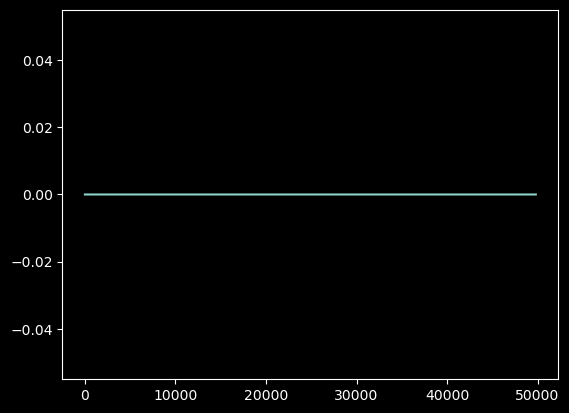

Final error: 0.0


In [18]:
def rolling_avg(lst, window):
    return (np.cumsum(lst[window:]) - np.cumsum(lst[:-window])) / window

plt.plot(rolling_avg(errors, 200))
plt.show()

final_error = sum(errors[-100:])/100
print(f"Final error: {final_error}")

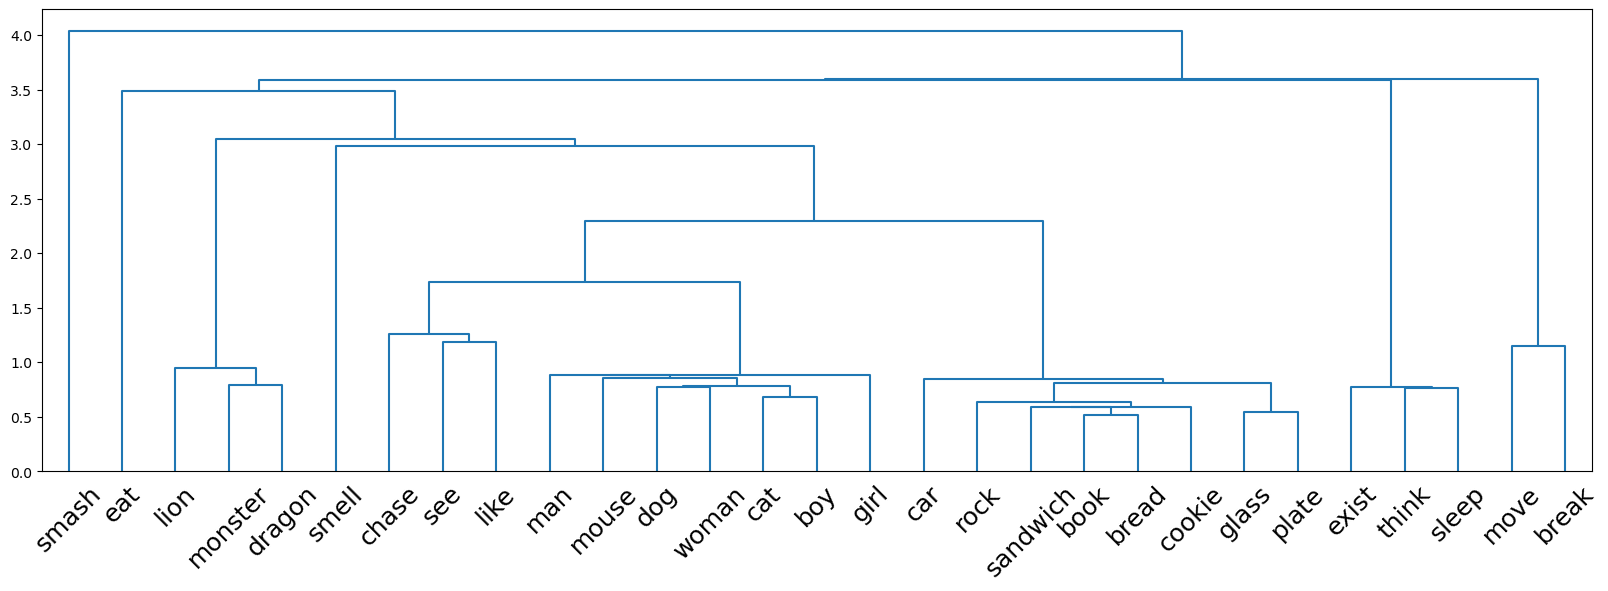

In [10]:
def plot_dendo(X, names, exclude=["<SOS>", "<EOS>"]):
    """
    Show hierarchical clustering of vectors
    
    Input
        X : numpy tensor [nitem x dim] such that each row is a vector to be clustered
        names : [length nitem] list of item names
        exclude: list of names we want to exclude
    """
    names = np.array(names)
    include = np.array([myname not in exclude for myname in names], dtype=bool)
    linked = linkage(X[include], "single", optimal_ordering=True)
    plt.figure(1, figsize=(20, 6))
    dendrogram(linked, labels=names[include], color_threshold=0, leaf_font_size=18)
    plt.show()


plot_dendo(rnn.get_embeddings(), unique_tokens)

(Note: your exact results may vary, but the general picture should be similar.)

We see that the model's embeddings encode significant information. The model seems to recover some of the categories built into the grammar (see the grammar.py file), classifying ['boy', 'man', 'girl', 'woman'] together, as well as ['dragon', 'monster', 'lion'] and ['cat', 'dog', 
'mouse'].

However, the model is not perfect: it fails to recover the `ANIMATE` category, as it places certain verbs like 'smell', 'eat', and 'chase'  etc. closer to 'man', 'woman', 'boy' than 'dragon', 'monster', and 'lion', all of which are animate.

Just for fun, let's see what sentences the model is able to generate.

In [11]:
def list_to_sentence(ls):
    sent = ""
    for word in ls:
        sent += word + " "
    return sent.strip()

def generate_sentence(max_len=15):
    
    # token = torch.tensor(random.randint(2, 30))
    token = torch.tensor(1)
    word = ints_to_tokens[int(token.item())]
    sentence = [word]
    # sentence = []
    hidden = rnn.initHidden()

    for _ in range(max_len):
        output, hidden = rnn(token, hidden)
        # token = torch.argmax(output)
        m = Categorical(output)
        token = m.sample()
        word = ints_to_tokens[int(token.item())]
        sentence.append(word)
        if word == '<EOS>':
            break

    return list_to_sentence(sentence)


for i in range(10):
    print(f"Sentence no. {i+1}: {generate_sentence()}")


Sentence no. 1: <SOS> girl break <EOS>
Sentence no. 2: <SOS> girl break <EOS>
Sentence no. 3: <SOS> girl break <EOS>
Sentence no. 4: <SOS> girl break <EOS>
Sentence no. 5: <SOS> girl break <EOS>
Sentence no. 6: <SOS> girl break <EOS>
Sentence no. 7: <SOS> girl break <EOS>
Sentence no. 8: <SOS> girl break <EOS>
Sentence no. 9: <SOS> girl break <EOS>
Sentence no. 10: <SOS> girl break <EOS>
